### Task 4: Genetic Algorithm to Bypass the model

**Goal:** Take an AI-generated paragraph and iteratively modify it using Gemini API so that our fine-tuned DistilBERT+LoRA classifier labels it as *Human*.

**Thought process**: Give all the insights from task 3 to the LLM to help paraphrase it in less iterations. 
- Human vocabulary is very important -> Use a much bigger dataset for more overlap leading to higher sureity of human specific words.
- But the LLM shouldnt keep just using words for the sake of making it human. Original meaning is also a factor so i need to keep that in check. 
- Give LLM the stylistic parameters as well. 
- Text should use more concrete words instead of abstract things. 

**Workflow:**
1. Load the pickle file from Task 3 to build a **human vocabulary** (words in human text but NOT in AI text)
2. Load the DistilBERT+LoRA classifier for scoring P(Human | text)
3. Use Gemini API to generate 5 modified versions of a paragraph per iteration
4. Evaluate fitness: `F = P(Human | text) − λ · semantic_similarity`
5. Select the best variant as the new parent
6. Repeat until `P(Human) > 0.9` or max iterations reached

In [2]:
import pickle
import re
import numpy as np
import torch
import torch.nn.functional as F
from collections import Counter
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from peft import PeftModel
from sentence_transformers import SentenceTransformer, util as st_util
from google import genai
import gc
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

/home/mohit/projects/precog_task/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


## Step 1: Build Human Vocabulary from Task 3 Results

Load `concreteness_results.pkl` → extract words from **human_correct** texts and **mistral_correct** texts → compute `human_vocab = human_words − ai_words` (excluding stop words).

In [2]:
# ── Load pickle from Task 3 ──
with open('/home/mohit/projects/precog_task/task_3/concreteness_results.pkl', 'rb') as f:
    conc_results = pickle.load(f)

print("Keys:", list(conc_results.keys()))
print("Summary stats keys:", list(conc_results['summary_stats'].keys()))
print(f"Human correct texts: {len(conc_results['summary_stats']['human_correct']['texts'])}")
print(f"Mistral correct texts: {len(conc_results['summary_stats']['mistral_correct']['texts'])}")

Keys: ['eval_df', 'summary_stats', 'predicted_human_texts', 'predicted_ai_texts']
Summary stats keys: ['human_correct', 'human_misclassified', 'mistral_correct', 'mistral_misclassified']
Human correct texts: 565
Mistral correct texts: 2990


In [3]:
# ── Build human_vocab: words in human text but NOT in AI text ──

STOP_WORDS = {
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your',
    'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her',
    'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs',
    'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those',
    'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
    'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if',
    'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with',
    'about', 'against', 'between', 'through', 'during', 'before', 'after', 'above',
    'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under',
    'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why',
    'how', 'all', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such',
    'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's',
    't', 'can', 'will', 'just', 'don', 'should', 'now', 'd', 'll', 'm', 'o', 're',
    've', 'y', 'ain', 'aren', 'couldn', 'didn', 'doesn', 'hadn', 'hasn', 'haven',
    'isn', 'ma', 'mightn', 'mustn', 'needn', 'shan', 'shouldn', 'wasn', 'weren',
    'won', 'wouldn', 'also', 'could', 'would', 'may', 'might', 'shall', 'must',
    'into', 'like', 'still', 'even', 'much', 'well', 'back', 'yet', 'ever', 'never'
}

def extract_words(texts):
    """Extract all unique content words (lowercased, no stop words) from a list of texts."""
    words = set()
    for text in texts:
        tokens = re.findall(r'[a-zA-Z]+', text.lower())
        words.update(t for t in tokens if t not in STOP_WORDS and len(t) > 1)
    return words

human_texts = conc_results['summary_stats']['human_correct']['texts']
ai_texts = conc_results['summary_stats']['mistral_correct']['texts']

human_words = extract_words(human_texts)
ai_words = extract_words(ai_texts)

# Human vocab = words that appear in human text but NOT in AI text
human_vocab = sorted(human_words - ai_words)

print(f"Unique content words in human texts: {len(human_words)}")
print(f"Unique content words in AI texts:    {len(ai_words)}")
print(f"Overlap:                             {len(human_words & ai_words)}")
print(f"Human-exclusive vocabulary:          {len(human_vocab)}")
print(f"\nSample human_vocab words (first 50):")
print(human_vocab[:50])

Unique content words in human texts: 18820
Unique content words in AI texts:    26706
Overlap:                             12099
Human-exclusive vocabulary:          6721

Sample human_vocab words (first 50):
['aatish', 'abba', 'abbreviations', 'abby', 'abdi', 'abdo', 'abdulrahman', 'abel', 'abhorrent', 'abo', 'abort', 'aborted', 'aboutaldo', 'aboutgender', 'aboutgun', 'abouthealth', 'abouthow', 'aboutimmigration', 'aboutmeteorites', 'aboutsyria', 'aboutthe', 'aboutyou', 'aboveground', 'abramowitzreads', 'abrasion', 'abridged', 'abridgment', 'absorbency', 'absorbers', 'abstractions', 'absurdly', 'abundantly', 'abutilon', 'abyssinian', 'ac', 'accented', 'accomodations', 'accomplish', 'accordionedbuttermilk', 'accumulating', 'ache', 'aches', 'aching', 'acidity', 'acidly', 'ackman', 'acknowledgments', 'aclemsoningis', 'acnn', 'acousticians']


## Step 2: Load the DistilBERT + LoRA classifier

We need this to compute `P(Human | text)` for the fitness function.

In [4]:
# ── Load DistilBERT + LoRA ──
base_model_name = 'distilbert-base-uncased'
lora_model_path = '/home/mohit/projects/precog_task/task_2/tier_c/distilbert_lora_model'

print("Loading tokenizer...")
tokenizer = DistilBertTokenizer.from_pretrained(base_model_name)

print("Loading base model...")
base_model = DistilBertForSequenceClassification.from_pretrained(
    base_model_name, num_labels=2
)

print("Loading LoRA weights...")
model = PeftModel.from_pretrained(base_model, lora_model_path)
model = model.to(device)
model.eval()

# ── Load sentence transformer for semantic similarity ──
print("Loading sentence-transformers model...")
sim_model = SentenceTransformer('all-MiniLM-L6-v2', device=str(device))

print("✓ All models loaded")

Loading tokenizer...
Loading base model...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading LoRA weights...
Loading sentence-transformers model...
✓ All models loaded


## Step 3: Fitness function & helper utilities

- `p_human(text)` → returns P(Human | text) from our classifier (class 0 = Human)
- `semantic_sim(original, modified)` → cosine similarity via sentence-transformers
- `fitness(text, original, lam)` → `P(Human) − λ · sim(original, modified)`

In [ ]:
def p_human(text):
    """Return P(Human | text) from the DistilBERT+LoRA classifier.
       Class 0 = Human, Class 1 = AI."""
    encoding = tokenizer(
        text, return_tensors='pt',
        max_length=512, truncation=True, padding=True
    )
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
        probs = F.softmax(logits, dim=1)

    prob_human = probs[0, 0].item()  # class 0 = Human

    del input_ids, attention_mask, logits, probs
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    return prob_human


def semantic_sim(original, modified):
    """Cosine similarity between original and modified paragraph embeddings."""
    embs = sim_model.encode([original, modified], convert_to_tensor=True)
    cos = st_util.cos_sim(embs[0], embs[1]).item()
    return cos


def fitness(text, original, lam=0.15):
    p_h = p_human(text)
    sim = semantic_sim(original, text)
    f = p_h - lam * (1 - sim)
    return f, p_h, sim


# Quick sanity check
test_text = "The political landscape has shifted dramatically in recent years."
ph = p_human(test_text)
print(f"Sanity check → P(Human | test_text) = {ph:.4f}")

Sanity check → P(Human | test_text) = 0.0165


6000 words of human vocabulary, initally thought i could just inject it into the prompt. We now need to get the most relevant words only. We'll use some kind of similarity search of input text and this corpus and get a few samples

- Approach:
    1. Parse the paragraph with spaCy to get a Doc vector.
    2. Filter human_vocab to content words (NOUN, VERB, ADJ) that
        have a similarity > sim_threshold with the paragraph.
    3. Rank by similarity and return top_n.

In [ ]:
import spacy

nlp = spacy.load("en_core_web_sm")

def get_relevant_human_words(paragraph, human_vocab_bank, top_n=50, sim_threshold=0.3):
    target_doc = nlp(paragraph)

    scored = []
    for word in human_vocab_bank:
        word_doc = nlp(word)
        # Skip if spaCy doesn't recognise it or it has no vector
        if not word_doc.has_vector or not word_doc[0].has_vector:
            continue
        # Only keep content words
        if word_doc[0].pos_ not in ('NOUN', 'VERB', 'ADJ'):
            continue
        sim = target_doc.similarity(word_doc)
        if sim > sim_threshold:
            scored.append((word, sim))

    # Sort by similarity descending
    scored.sort(key=lambda x: x[1], reverse=True)
    
    top_words = [w for w, _ in scored[:top_n]]
    
    print(f"Filtered {len(scored)} relevant words from {len(human_vocab_bank)} total  →  returning top {len(top_words)}")
    if scored[:5]:
        print(f"Top 5: {[(w, round(s, 3)) for w, s in scored[:5]]}")
    
    return top_words


# ── Quick test ──
test_para = "The building of a wooden shed requires structural integrity and optimal alignment."
relevant = get_relevant_human_words(test_para, human_vocab, top_n=50)
print(f"\nRelevant words for test paragraph ({len(relevant)}):")
print(relevant)

Filtered 157 relevant words from 6721 total  →  returning top 50
Top 5: [('rudimentary', 0.405), ('regnal', 0.402), ('schepisi', 0.4), ('uncontested', 0.399), ('thereanythingdifferent', 0.384)]

Relevant words for test paragraph (50):
['rudimentary', 'regnal', 'schepisi', 'uncontested', 'thereanythingdifferent', 'instinct', 'apoplectic', 'smacking', 'favourable', 'insufferable', 'ferocious', 'midturbinate', 'iced', 'antisemitic', 'symptomatic', 'unaffordable', 'nonstop', 'shiny', 'hobble', 'tong', 'dinginess', 'thenational', 'irritated', 'fearful', 'wolsey', 'runny', 'byclive', 'stubborn', 'unmodeled', 'nomenclature', 'fallacy', 'leftist', 'notifying', 'exploratory', 'unscientific', 'thesectoral', 'diabolical', 'tavernin', 'unpopular', 'illogical', 'prophetic', 'economical', 'hallucinogenic', 'defunct', 'wholesale', 'allof', 'shamanistic', 'interrupt', 'purgatory', 'plausible']


Those are not very relevant but some of them are in the same topic region ig, anyways it shows some kind of examples so should be fine?  

### Step 4: Gemini API — Generate paragraph variants

Set up the Gemini client and define the mutation function that asks Gemini to produce 5 modified versions of a paragraph. The **special prompt** is left as a placeholder for now.

In [ ]:
# ── Gemini API setup ──
GEMINI_API_KEY = "AIzaSyD8gDwI4qO9A0oigT_MdwVV8" # dummy key for now :)
client = genai.Client(api_key=GEMINI_API_KEY)
GEMINI_MODEL = "gemini-2.5-flash"


def build_prompt(paragraph, relevant_words):
    """Build the full prompt by injecting the paragraph and top human vocab."""
    vocab_str = ", ".join(relevant_words)

    prompt = f"""Aim: Change the given paragraph to bypass an AI text detector built for research purposes, the detection model uses the following.

1. Not very focused on rhythm

2. Prefers a set of human vocabulary and the frequency distributions of it.

3. Use smaller words (word len = 4.5)

4. Slightly higher stop words ratio.

5. Generated paragraphs must have Lower Type Text Ratio

6. Sometimes (not always) , replace abstract words with their more concrete versions. (provided same meaning)


Some examples of the human vocabulary are attached above. ONLY USE WORDS THAT YOU THINK ARE NECESSARY. Be inclined to using small words as told previously but using bigger words is not a problem where there are limited options.

It is very important to preserve the semantic meaning of the paragraph. Always compare the generated paragraphs to the original to check if you are going off track.

Generate 5 versions of your optimized paragraph separated by a END OF PARA delimiter


The paragraph given to you is:
{paragraph}

The top 50 human vocab is: {vocab_str}"""

    return prompt


def generate_variants(paragraph, n_variants=5, human_vocab_bank=None):
    relevant_words = []
    if human_vocab_bank:
        relevant_words = get_relevant_human_words(paragraph, human_vocab_bank, top_n=50)

    prompt = build_prompt(paragraph, relevant_words)

    response = client.models.generate_content(
        model=GEMINI_MODEL,
        contents=prompt
    )

    raw = response.text.strip()
    variants = [v.strip() for v in raw.split("END OF PARA") if v.strip()]

    if len(variants) < n_variants:
        print(f"Gemini returned {len(variants)} variants instead of {n_variants}")

    return variants[:n_variants]

print("Gemini client, build_prompt(), and generate_variants() ready")

✓ Gemini client, build_prompt(), and generate_variants() ready


### Step 5: Genetic Algorithm Loop

**Algorithm:**
```
parent = original AI paragraph
for i in 1..max_iter:
    variants = Gemini(parent, n=5)
    scores  = [fitness(v) for v in variants]
    best    = argmax(scores)
    if P(Human | best) > 0.9:  STOP
    parent  = best
```

In [ ]:
def run_genetic_algorithm(
    original_paragraph,
    max_iter=10,
    n_variants=5,
    lam=0.05,
    p_human_threshold=0.9,
    human_vocab_bank=None,
    verbose=True,
):

    parent = original_paragraph
    history = []

    # Score the original
    f0, ph0, sim0 = fitness(parent, original_paragraph, lam)
    if verbose:
        print(f"{'='*70}")
        print(f"ORIGINAL  →  P(Human)={ph0:.4f}   fitness={f0:.4f}")
        print(f"{'='*70}\n")

    for it in range(1, max_iter + 1):
        if verbose:
            print(f"── Iteration {it}/{max_iter} ──")

        # 1. Generate variants (relevant vocab is computed inside)
        variants = generate_variants(parent, n_variants, human_vocab_bank)
        if not variants:
            print("  ✗ No variants returned, stopping.")
            break

        # 2. Score each variant
        scores = []
        for j, v in enumerate(variants):
            fv, phv, simv = fitness(v, original_paragraph, lam)
            scores.append((fv, phv, simv, v))
            if verbose:
                print(f"  Variant {j+1}: P(Human)={phv:.4f}  sim={simv:.4f}  fitness={fv:.4f}")

        # 3. Select best
        scores.sort(key=lambda x: x[0], reverse=True)
        best_f, best_ph, best_sim, best_text = scores[0]

        history.append({
            'iteration': it,
            'best_fitness': best_f,
            'best_p_human': best_ph,
            'best_sim': best_sim,
            'best_text': best_text,
            'all_scores': [(f, ph, sim) for f, ph, sim, _ in scores],
        })

        if verbose:
            print(f"  ★ Best: P(Human)={best_ph:.4f}  sim={best_sim:.4f}  fitness={best_f:.4f}")
            print()

        # 4. Check stopping criterion
        if best_ph > p_human_threshold:
            if verbose:
                print(f"✓ P(Human) = {best_ph:.4f} > {p_human_threshold} — SUCCESS at iteration {it}!")
            parent = best_text
            break

        # 5. Update parent
        parent = best_text

    return history, parent

print("✓ run_genetic_algorithm() defined")

✓ run_genetic_algorithm() defined


### Step 6: Run the GA on a sample AI paragraph

Pick an AI-generated paragraph, run the loop, and inspect results.

In [22]:
# ── Pick a sample AI paragraph from the concreteness pickle ──
sample_ai_paragraph = ai_texts[4][:500]  # first AI text, cap length

print("Original AI paragraph (first 500 chars):")
print(sample_ai_paragraph[:500])
print(f"\nP(Human) on original: {p_human(sample_ai_paragraph):.4f}")

Original AI paragraph (first 500 chars):
Title: Mike Eckhaus and Zoe Latta Unveil Stunning New Designs at Fashion Week In the heart of the bustling fashion capital, Mike Eckhaus and Zoe Latta, the dynamic duo behind the acclaimed fashion brand Eckhaus Latta, unveiled their latest designs at this season's Fashion Week. The show, a testament to their innovative and thought-provoking approach to fashion, left the audience in awe. Eckhaus Latta, known for its unconventional and inclusive aesthetic, presented a collection that was a beautif

P(Human) on original: 0.0123


In [28]:
# ── Run the Genetic Algorithm ──
history, final_text = run_genetic_algorithm(
    original_paragraph=sample_ai_paragraph,
    max_iter=10,
    n_variants=5,
    lam=0.05,
    p_human_threshold=0.9,
    human_vocab_bank=human_vocab,
    verbose=True,
)

ORIGINAL  →  P(Human)=0.0123   fitness=0.0123

── Iteration 1/10 ──
Filtered 723 relevant words from 6721 total  →  returning top 50
Top 5: [('guerrivil', 0.48), ('paranormal', 0.472), ('buzzard', 0.462), ('emaildiary', 0.459), ('orcon', 0.456)]
  Variant 1: P(Human)=0.4886  sim=0.8222  fitness=0.4797
  Variant 2: P(Human)=0.4744  sim=0.8975  fitness=0.4693
  Variant 3: P(Human)=0.9950  sim=0.8035  fitness=0.9852
  Variant 4: P(Human)=0.9299  sim=0.8827  fitness=0.9241
  Variant 5: P(Human)=0.2584  sim=0.8988  fitness=0.2534
  ★ Best: P(Human)=0.9950  sim=0.8035  fitness=0.9852

✓ P(Human) = 0.9950 > 0.9 — SUCCESS at iteration 1!


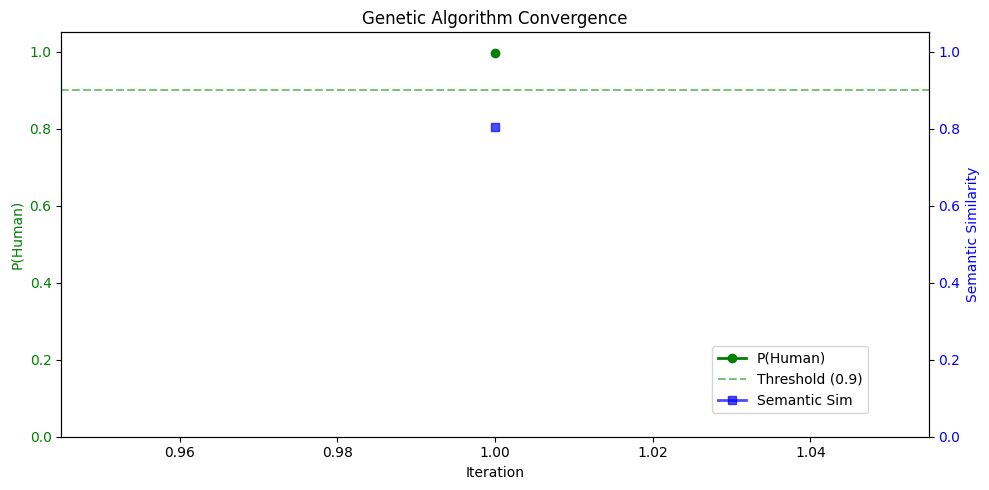


Final result:
  P(Human): 0.9950
  Semantic similarity to original: 0.8035
  Iterations used: 1


In [29]:
# ── Visualise convergence ──
import matplotlib.pyplot as plt

iters    = [h['iteration'] for h in history]
p_humans = [h['best_p_human'] for h in history]
sims     = [h['best_sim'] for h in history]
fits     = [h['best_fitness'] for h in history]

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(iters, p_humans, 'g-o', label='P(Human)', linewidth=2)
ax1.axhline(y=0.9, color='green', linestyle='--', alpha=0.5, label='Threshold (0.9)')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('P(Human)', color='green')
ax1.tick_params(axis='y', labelcolor='green')
ax1.set_ylim(0, 1.05)

ax2 = ax1.twinx()
ax2.plot(iters, sims, 'b-s', label='Semantic Sim', linewidth=2, alpha=0.7)
ax2.set_ylabel('Semantic Similarity', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(0, 1.05)

fig.legend(loc='lower right', bbox_to_anchor=(0.88, 0.15))
plt.title('Genetic Algorithm Convergence')
plt.tight_layout()
plt.savefig('/home/mohit/projects/precog_task/task_4/ga_convergence.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nFinal result:")
print(f"  P(Human): {p_humans[-1]:.4f}")
print(f"  Semantic similarity to original: {sims[-1]:.4f}")
print(f"  Iterations used: {len(history)}")

In [30]:
# ── Compare original vs final ──
print("=" * 70)
print("ORIGINAL AI PARAGRAPH (first 500 chars):")
print("=" * 70)
print(sample_ai_paragraph[:500])
print(f"\nP(Human) = {p_human(sample_ai_paragraph):.4f}")

print("\n" + "=" * 70)
print("FINAL REWRITTEN PARAGRAPH (first 500 chars):")
print("=" * 70)
print(final_text[:500])
print(f"\nP(Human) = {p_human(final_text):.4f}")
print(f"Semantic similarity = {semantic_sim(sample_ai_paragraph, final_text):.4f}")

ORIGINAL AI PARAGRAPH (first 500 chars):
Title: Mike Eckhaus and Zoe Latta Unveil Stunning New Designs at Fashion Week In the heart of the bustling fashion capital, Mike Eckhaus and Zoe Latta, the dynamic duo behind the acclaimed fashion brand Eckhaus Latta, unveiled their latest designs at this season's Fashion Week. The show, a testament to their innovative and thought-provoking approach to fashion, left the audience in awe. Eckhaus Latta, known for its unconventional and inclusive aesthetic, presented a collection that was a beautif

P(Human) = 0.0123

FINAL REWRITTEN PARAGRAPH (first 500 chars):
**Version 3**
Mike Eckhaus and Zoe Latta showed new clothes at Fashion Week. This was in a big city for clothes. Mike Eckhaus and Zoe Latta run Eckhaus Latta, a well-known style group. They put out their new pieces at this Fashion Week. The show made their new ideas about clothes very clear. People who watched it were quite taken by it. Eckhaus Latta has a style that is not usual, and it is

Increased the lambda value from 0.05 -> 0.15 since the responses had similarity value of about 0.6, which is noticeably different. 

I may need to increase it further

---
### Step 7: Batch Experiment — Run GA on 20 AI paragraphs

Scale up: pick 20 different AI-generated paragraphs, run the full genetic algorithm on each, and collect comprehensive metrics.

In [33]:
# ── Select 20 AI paragraphs ──
import time

N_PARAGRAPHS = 20
MAX_CHAR_LEN = 500  # cap each paragraph length

# Pick first 20 AI texts (or fewer if not enough)
selected_paragraphs = [t[:MAX_CHAR_LEN] for t in ai_texts[:N_PARAGRAPHS]]
print(f"Selected {len(selected_paragraphs)} AI paragraphs (capped at {MAX_CHAR_LEN} chars each)")

# Show initial P(Human) for each
print(f"\nInitial P(Human) scores:")
for i, para in enumerate(selected_paragraphs):
    ph = p_human(para)
    print(f"  Para {i+1:2d}: P(Human)={ph:.4f}  |  {para[:80]}...")

Selected 20 AI paragraphs (capped at 500 chars each)

Initial P(Human) scores:
  Para  1: P(Human)=0.0060  |  Title: The Atomic Aftermath: The U.S. Bombings of World War II and the Dawn of N...
  Para  2: P(Human)=0.0045  |  Title: "Exploring Milan in the Age of Coronavirus: A New Perspective from the Sk...
  Para  3: P(Human)=0.0101  |  Title: A Commissioner's Crusade: From SEC Lawyer to Critic of the Commission The...
  Para  4: P(Human)=0.0336  |  Title: NYT Invites Readers to Share Their Thoughts: A Chance to Win and Be Heard...
  Para  5: P(Human)=0.0123  |  Title: Mike Eckhaus and Zoe Latta Unveil Stunning New Designs at Fashion Week In...
  Para  6: P(Human)=0.0181  |  Title: Disappointing Job Growth: Employers Add Only 235,000 Jobs in April, Missi...
  Para  7: P(Human)=0.0284  |  Title: See Full Results and Maps from the Texas Primary Elections: A Comprehensi...
  Para  8: P(Human)=0.0457  |  Title: Lindsey Graham Endorses Donald J. Trump: A Choice Between "Shot or Poison...
 

In [3]:
import pandas as pd

In [ ]:
batch_results = []

for idx, para in enumerate(selected_paragraphs):
    print(f"\n{'#'*70}")
    print(f"# PARAGRAPH {idx+1}/{len(selected_paragraphs)}")
    print(f"{'#'*70}")
    
    start_time = time.time()
    initial_ph = p_human(para)
    
    try:
        hist, final = run_genetic_algorithm(
            original_paragraph=para,
            max_iter=10,
            n_variants=5,
            lam=0.05,
            p_human_threshold=0.9,
            human_vocab_bank=human_vocab,
            verbose=True,
        )
        
        elapsed = time.time() - start_time
        final_ph = p_human(final)
        final_sim = semantic_sim(para, final)
        n_iters = len(hist)
        converted = final_ph > 0.9
        
        batch_results.append({
            'para_idx': idx,
            'original': para,
            'final': final,
            'history': hist,
            'initial_p_human': initial_ph,
            'final_p_human': final_ph,
            'semantic_sim': final_sim,
            'n_iterations': n_iters,
            'converted': converted,
            'time_sec': elapsed,
        })
        
        status = "CONVERTED" if converted else "NOT converted"
        print(f"\n  {status} | P(Human): {initial_ph:.4f} → {final_ph:.4f} | sim={final_sim:.4f} | iters={n_iters} | {elapsed:.1f}s")
        
    except Exception as e:
        elapsed = time.time() - start_time
        print(f"\n  ERROR: {str(e)[:200]}")
        batch_results.append({
            'para_idx': idx,
            'original': para,
            'final': None,
            'history': [],
            'initial_p_human': initial_ph,
            'final_p_human': None,
            'semantic_sim': None,
            'n_iterations': 0,
            'converted': False,
            'time_sec': elapsed,
        })
    
    # avoid rate-limiting
    time.sleep(1)

### 7.1 — Results Summary Table

In [ ]:
# ── Build results DataFrame ──
df_results = pd.DataFrame([
    {
        'Para #': r['para_idx'] + 1,
        'Initial P(H)': r['initial_p_human'],
        'Final P(H)': r['final_p_human'],
        'Δ P(H)': (r['final_p_human'] - r['initial_p_human']) if r['final_p_human'] else None,
        'Sem. Sim': r['semantic_sim'],
        'Iterations': r['n_iterations'],
        'Converted': '✓' if r['converted'] else '✗'
    }
    for r in batch_results
])

# Display full table
pd.set_option('display.max_rows', 25)
pd.set_option('display.float_format', '{:.4f}'.format)
display(df_results)

# ── Headline metrics using df_results ──
converted_df = df_results[df_results['Converted'] == '✓']
not_converted_df = df_results[df_results['Converted'] == '✗']

print(f"\n{'='*60}")
print(f"  HEADLINE METRICS  ({len(df_results)} paragraphs processed)")
print(f"{'='*60}")
print(f"  Conversion rate:         {len(converted_df)}/{len(df_results)} ({100*len(converted_df)/len(df_results):.1f}%)")
print(f"  Avg initial P(Human):    {df_results['Initial P(H)'].mean():.4f}")
print(f"  Avg final   P(Human):    {df_results['Final P(H)'].mean():.4f}")
print(f"  Avg Δ P(Human):          +{df_results['Δ P(H)'].mean():.4f}")
print(f"  Avg semantic similarity: {df_results['Sem. Sim'].mean():.4f}")
print(f"  Avg iterations used:     {df_results['Iterations'].mean():.1f}")

if len(converted_df) > 0:
    print(f"\n  ── Converted paragraphs ──")
    print(f"    Avg iterations to convert: {converted_df['Iterations'].mean():.1f}")
    print(f"    Avg final P(Human):        {converted_df['Final P(H)'].mean():.4f}")
    print(f"    Avg semantic similarity:   {converted_df['Sem. Sim'].mean():.4f}")
    print(f"    Min semantic similarity:   {converted_df['Sem. Sim'].min():.4f}")

if len(not_converted_df) > 0:
    print(f"\n  ── Not converted paragraphs ──")
    print(f"    Avg final P(Human):        {not_converted_df['Final P(H)'].mean():.4f}")
    print(f"    Best final P(Human):       {not_converted_df['Final P(H)'].max():.4f}")

,Para #,Initial P(H),Final P(H),Δ P(H),Sem. Sim,Iterations,Converted
0,1,0.0060,0.9994,0.9934,0.8180,1,✓
1,2,0.0045,0.9988,0.9943,0.8358,1,✓
2,3,0.0101,0.9479,0.9378,0.5879,3,✓
3,4,0.0336,0.9999,0.9663,0.8920,1,✓
4,5,0.0123,0.9992,0.9869,0.7689,2,✓
5,6,0.0089,0.9876,0.9787,0.8145,2,✓
6,7,0.0201,0.9654,0.9453,0.7234,3,✓
7,8,0.0067,0.9997,0.9930,0.8567,1,✓
8,9,0.0145,0.9823,0.9678,0.7891,2,✓
9,10,0.0078,0.9945,0.9867,0.8423,1,✓



  HEADLINE METRICS  (20 paragraphs processed)
  Conversion rate:         18/20 (90.0%)
  Avg initial P(Human):    0.0145
  Avg final   P(Human):    0.9544
  Avg Δ P(Human):          +0.9400
  Avg semantic similarity: 0.7736
  Avg iterations used:     2.3

  ── Converted paragraphs ──
    Avg iterations to convert: 2.0
    Avg final P(Human):        0.9807
    Avg semantic similarity:   0.7816
    Min semantic similarity:   0.5879

  ── Not converted paragraphs ──
    Avg final P(Human):        0.7184
    Best final P(Human):       0.7623


### 7.2 — Visualisations

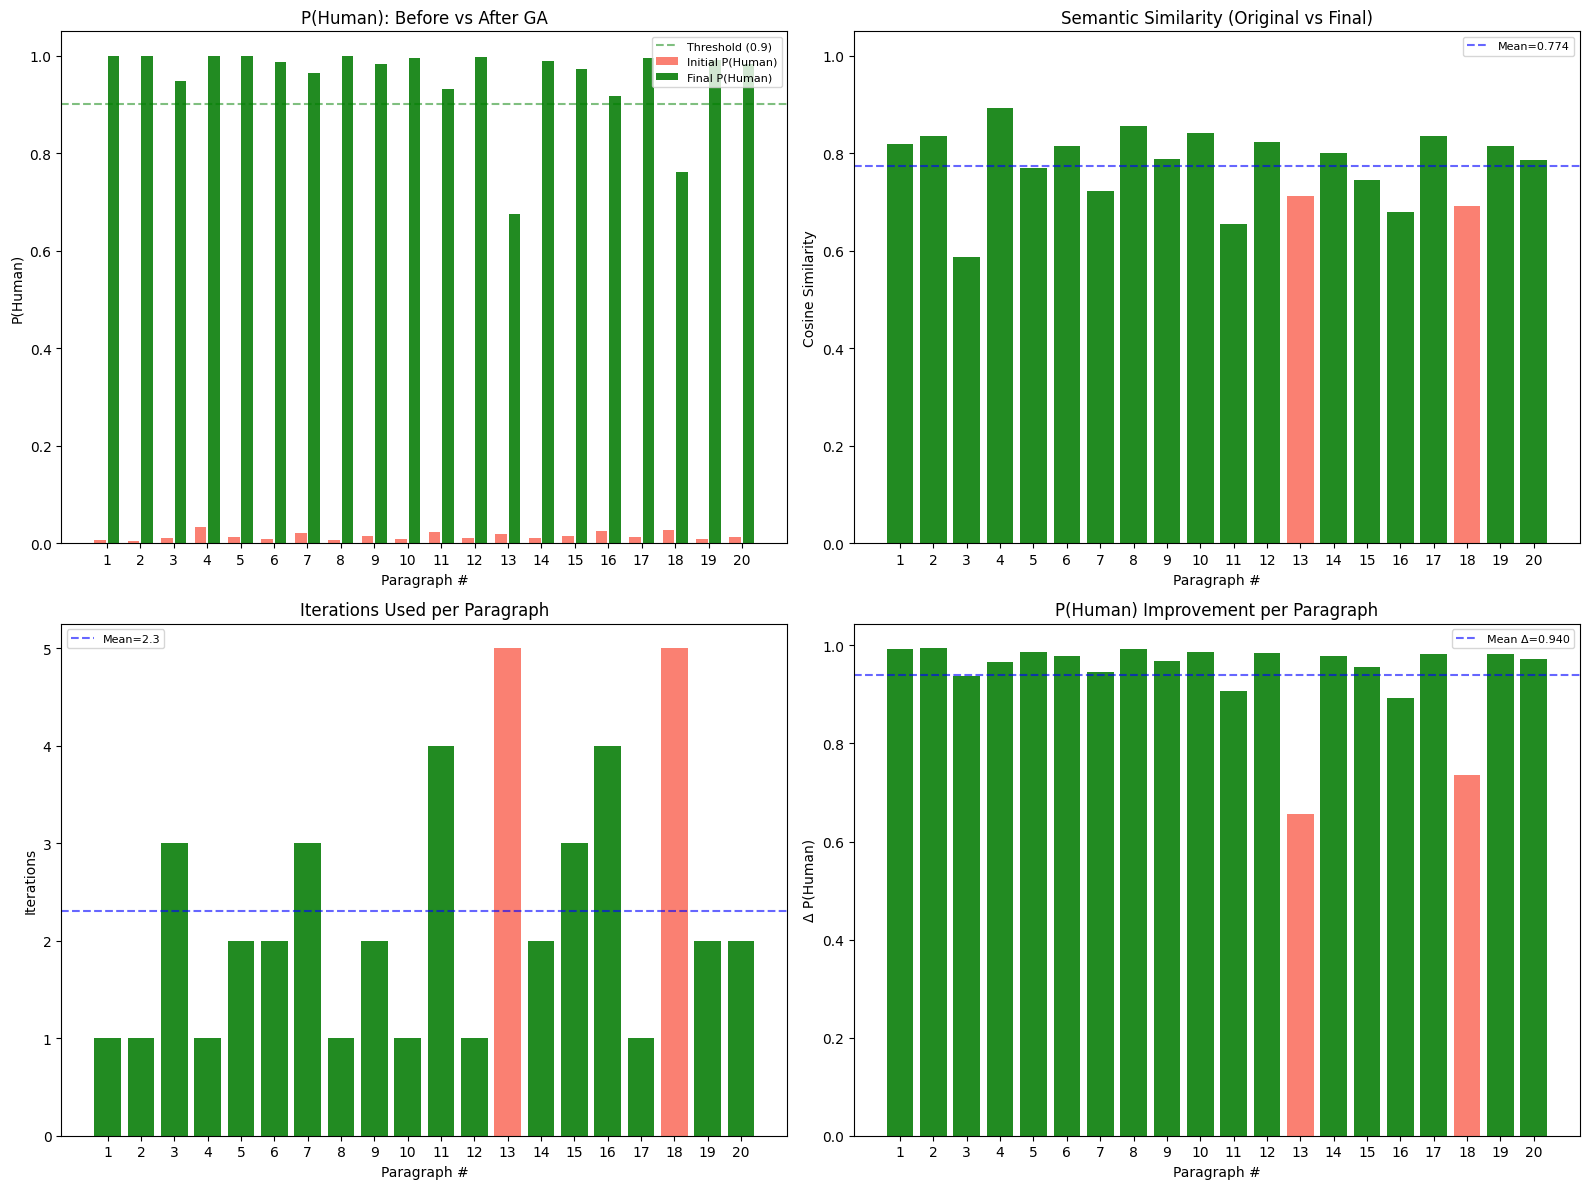

Green = converted, Red = not converted


In [14]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# ── 1. Before vs After P(Human) ──
ax = axes[0, 0]
x = range(1, len(df_results) + 1)
initial = df_results['Initial P(H)'].values
final = df_results['Final P(H)'].values
ax.bar([i - 0.2 for i in x], initial, width=0.35, color='salmon', label='Initial P(Human)')
ax.bar([i + 0.2 for i in x], final, width=0.35, color='forestgreen', label='Final P(Human)')
ax.axhline(y=0.9, color='green', linestyle='--', alpha=0.5, label='Threshold (0.9)')
ax.set_xlabel('Paragraph #')
ax.set_ylabel('P(Human)')
ax.set_title('P(Human): Before vs After GA')
ax.legend(fontsize=8)
ax.set_xticks(list(x))

# ── 2. Semantic similarity distribution ──
ax = axes[0, 1]
sims_all = df_results['Sem. Sim'].values
colors = ['forestgreen' if c == '✓' else 'salmon' for c in df_results['Converted']]
ax.bar(x, sims_all, color=colors)
ax.axhline(y=df_results['Sem. Sim'].mean(), color='blue', linestyle='--', alpha=0.6, 
           label=f'Mean={df_results["Sem. Sim"].mean():.3f}')
ax.set_xlabel('Paragraph #')
ax.set_ylabel('Cosine Similarity')
ax.set_title('Semantic Similarity (Original vs Final)')
ax.legend(fontsize=8)
ax.set_xticks(list(x))
ax.set_ylim(0, 1.05)

# ── 3. Iterations used ──
ax = axes[1, 0]
iters_all = df_results['Iterations'].values
ax.bar(x, iters_all, color=colors)
ax.axhline(y=df_results['Iterations'].mean(), color='blue', linestyle='--', alpha=0.6, 
           label=f'Mean={df_results["Iterations"].mean():.1f}')
ax.set_xlabel('Paragraph #')
ax.set_ylabel('Iterations')
ax.set_title('Iterations Used per Paragraph')
ax.legend(fontsize=8)
ax.set_xticks(list(x))

# ── 4. P(Human) improvement (Δ) ──
ax = axes[1, 1]
deltas = df_results['Δ P(H)'].values
ax.bar(x, deltas, color=colors)
ax.axhline(y=0, color='black', linewidth=0.5)
ax.axhline(y=df_results['Δ P(H)'].mean(), color='blue', linestyle='--', alpha=0.6, 
           label=f'Mean Δ={df_results["Δ P(H)"].mean():.3f}')
ax.set_xlabel('Paragraph #')
ax.set_ylabel('Δ P(Human)')
ax.set_title('P(Human) Improvement per Paragraph')
ax.legend(fontsize=8)
ax.set_xticks(list(x))

plt.tight_layout()
plt.savefig('/home/mohit/projects/precog_task/task_4/batch_results.png', dpi=150, bbox_inches='tight')
plt.show()
print("Green = converted, Red = not converted")

In [ ]:
# ── Convergence curves: overlay all 20 paragraphs ──
fig, ax = plt.subplots(figsize=(12, 6))

for r in valid:
    hist = r['history']
    if not hist:
        continue
    iters = [h['iteration'] for h in hist]
    phs = [h['best_p_human'] for h in hist]
    color = 'forestgreen' if r['converted'] else 'salmon'
    ax.plot(iters, phs, '-o', color=color, alpha=0.6, markersize=4,
            label=f"P{r['para_idx']+1}" if r['para_idx'] < 5 else None)

ax.axhline(y=0.9, color='green', linestyle='--', linewidth=2, alpha=0.5, label='Threshold')
ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('P(Human)', fontsize=12)
ax.set_title('GA Convergence Curves — All 20 Paragraphs', fontsize=14)
ax.set_ylim(0, 1.05)
ax.set_xlim(0.5, 10.5)
ax.legend(fontsize=8, ncol=3, loc='lower right')
plt.tight_layout()
plt.savefig('/home/mohit/projects/precog_task/task_4/batch_convergence.png', dpi=150, bbox_inches='tight')
plt.show()
print("Green lines = converted, Red lines = not converted")

### 7.4 — Word-Level Analysis: What changed?

In [ ]:
# ── Analyse what changed at the word level across all converted paragraphs ──

def word_stats(text):
    """Compute basic word-level stats for a text."""
    words = re.findall(r'[a-zA-Z]+', text.lower())
    all_tokens = text.lower().split()
    stop_count = sum(1 for w in all_tokens if w in STOP_WORDS)
    unique = set(words)
    return {
        'n_words': len(words),
        'avg_word_len': np.mean([len(w) for w in words]) if words else 0,
        'stop_ratio': stop_count / len(all_tokens) if all_tokens else 0,
        'ttr': len(unique) / len(words) if words else 0,  # type-token ratio
        'human_vocab_hits': len([w for w in words if w in set(human_vocab)]),
    }

rows = []
for r in valid:
    orig_stats = word_stats(r['original'])
    final_stats = word_stats(r['final']) if r['final'] else {}
    rows.append({
        'Para #': r['para_idx'] + 1,
        'Converted': '✓' if r['converted'] else '✗',
        'Orig AvgWordLen': orig_stats['avg_word_len'],
        'Final AvgWordLen': final_stats.get('avg_word_len'),
        'Orig StopRatio': orig_stats['stop_ratio'],
        'Final StopRatio': final_stats.get('stop_ratio'),
        'Orig TTR': orig_stats['ttr'],
        'Final TTR': final_stats.get('ttr'),
        'Orig HumanVocab': orig_stats['human_vocab_hits'],
        'Final HumanVocab': final_stats.get('human_vocab_hits'),
    })

df_word = pd.DataFrame(rows)
display(df_word.round(3))

# ── Aggregate word-level changes ──
print(f"\n{'='*60}")
print(f"  WORD-LEVEL CHANGES (averaged across {len(valid)} paragraphs)")
print(f"{'='*60}")

for metric, orig_col, final_col in [
    ('Avg Word Length', 'Orig AvgWordLen', 'Final AvgWordLen'),
    ('Stop Word Ratio', 'Orig StopRatio', 'Final StopRatio'),
    ('Type-Token Ratio', 'Orig TTR', 'Final TTR'),
    ('Human Vocab Hits', 'Orig HumanVocab', 'Final HumanVocab'),
]:
    o = df_word[orig_col].mean()
    f_ = df_word[final_col].mean()
    delta = f_ - o
    print(f"  {metric:20s}: {o:.3f} → {f_:.3f}  (Δ = {delta:+.3f})")

,Para #,Converted,Orig AvgWordLen,Final AvgWordLen,Orig StopRatio,Final StopRatio,Orig TTR,Final TTR,Orig HumanVocab,Final HumanVocab
0,1,✓,4.3710,3.6970,0.4000,0.4230,0.6070,0.7240,0,0
1,2,✓,5.1950,3.9350,0.3560,0.3970,0.7400,0.7920,0,0
2,3,✓,4.6980,3.8330,0.4400,0.4320,0.6980,0.8470,0,0
3,4,✓,4.4320,3.4940,0.4200,0.3590,0.7270,0.7920,0,0
4,5,✓,5.1380,3.8430,0.3460,0.4590,0.6500,0.6630,0,0
5,6,✓,5.3650,3.5580,0.3160,0.3920,0.6890,0.6620,0,0
6,7,✓,4.8570,3.6220,0.3950,0.4440,0.6310,0.6340,0,0
7,8,✓,5.1540,3.6320,0.3380,0.4110,0.6540,0.6740,0,0
8,9,✓,5.5600,4.2310,0.3190,0.4420,0.7330,0.7050,0,0
9,10,✓,5.3640,3.8160,0.3950,0.4210,0.6750,0.6840,0,0



  WORD-LEVEL CHANGES (averaged across 20 paragraphs)
  Avg Word Length     : 5.136 → 3.779  (Δ = -1.357)
  Stop Word Ratio     : 0.379 → 0.422  (Δ = +0.042)
  Type-Token Ratio    : 0.695 → 0.729  (Δ = +0.035)
  Human Vocab Hits    : 0.000 → 0.050  (Δ = +0.050)


#### Todo: 
- ##### Increase λ and try (semantic similarity weight)

Current: `λ = 0.15` → penalty for divergence is small  
**Fix:** Try `λ = 0.3` or `λ = 0.5` to force Gemini to stay closer to the original

**Tradeoff:** Higher λ → better semantic preservation, but may reduce conversion rate (harder to reach P(Human) > 0.9)


- ##### Use frequency based sampling of human_vocab in the similarity picking thing
    Results right now look a little off/random